# Car Purchase Prediction

## Project goal

This project aims to build a model that can predict if customer is going to purchase a car or no

## Data description

This dataset contains details of 1000 customers who intend to buy a car.

Columns:
* User ID
* Gender
* Age
* Annual Salary
* Purchase Decision (No = 0; Yes = 1)

## Packages Used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import seaborn as sns
from sklearn import linear_model 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,roc_curve, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier
from sklearn import svm
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

## importing Data

In [2]:
car = pd.read_csv('car_data.csv')
car= car.drop('User ID', axis = 1)
car.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


In [3]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Gender        1000 non-null   object
 1   Age           1000 non-null   int64 
 2   AnnualSalary  1000 non-null   int64 
 3   Purchased     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


## EDA

### distributions

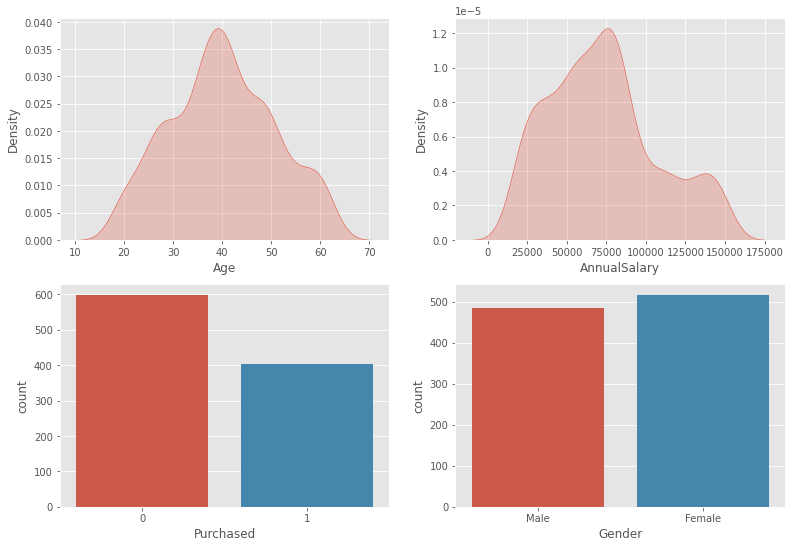

In [4]:
fig, axes = plt.subplots(2,2, figsize = (13,9))
sns.kdeplot(car.Age, shade = True, ax = axes[0,0])
sns.kdeplot(car.AnnualSalary, shade = True, ax = axes[0,1])
sns.countplot(data = car, x = 'Purchased', ax = axes[1,0])
sns.countplot(data = car, x= 'Gender', ax = axes[1,1])
plt.show()

In [5]:
car['Purchased'].value_counts()

0    598
1    402
Name: Purchased, dtype: int64

From the graphs : 
* Age seems normaly distributed through all customers
* there are more female customers than males
* people who will purchase the product are less than the ones who wont (40,2% vs 59.8%)

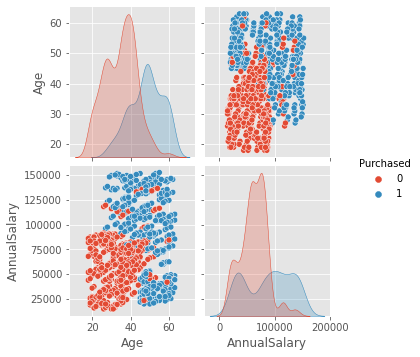

In [6]:
sns.pairplot(car, hue = 'Purchased')
plt.show()

##### AGE

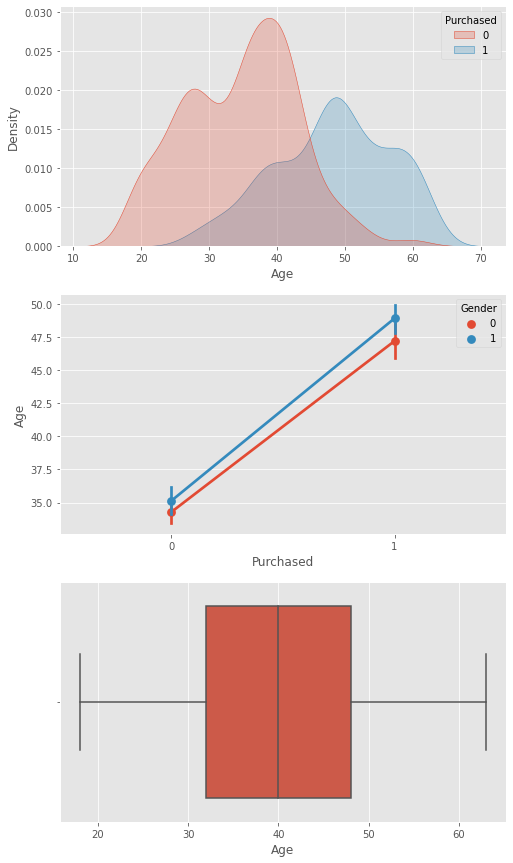

In [106]:
fig, axes = plt.subplots(3,1, figsize = (8,15))
sns.kdeplot(data = car,x= 'Age', hue = 'Purchased' , shade = True, ax = axes[0])
sns.pointplot(data = car, x = 'Purchased', y  ='Age', hue="Gender",ax = axes[1])
sns.boxplot(data = car,x = 'Age',ax = axes[2])

plt.show()

* People with an older age are more likely to purchase the product, as we can see from the first distribution plot, most of people who purchased are over the age of 40, while most of the non buyers are less than 40. also we can see that from the point plot as older age means higher chance of purchasing.
* We can also see the absence of outliers from the boxplot

##### Annual Salary

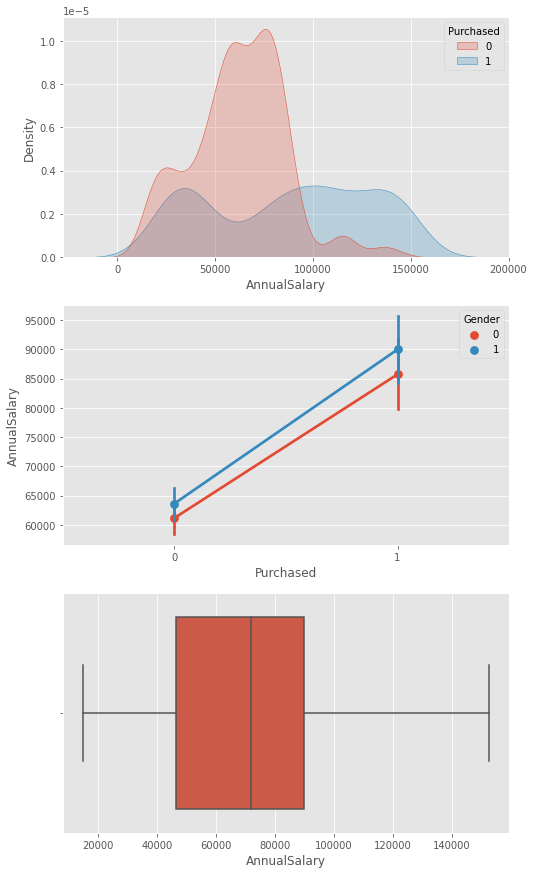

In [105]:
fig, axes = plt.subplots(3,1, figsize = (8,15))
sns.kdeplot(data = car, x = 'AnnualSalary', hue = 'Purchased', shade = True, ax = axes[0])
sns.pointplot(data = car, x = 'Purchased', y  ='AnnualSalary', hue="Gender", ax = axes[1])
sns.boxplot(data = car, x ='AnnualSalary', ax = axes[2])
plt.show()

* People with an older age are more likely to purchase the product, as we can see from the first distribution plot, most of people who purchased are over the age of 40, while most of the non buyers are less than 40. also we can see that from the point plot as older age means higher chance of purchasing
* We can also see the absence of outliers from the boxplot

In [11]:
car.groupby(car['Purchased'] == 1).mean()

,Age,AnnualSalary,Purchased
Purchased,,,
False,34.700669,62373.745819,0.0
True,48.146766,88033.582090,1.0


##### Gender

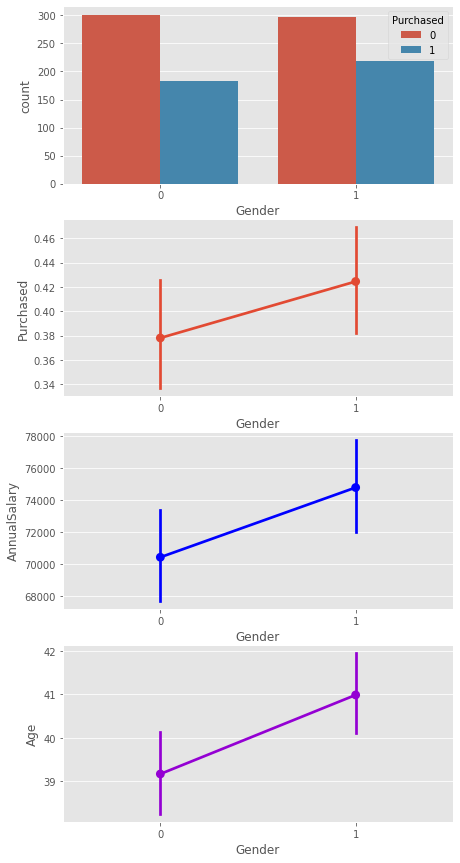

In [111]:
fig, axes = plt.subplots(4,1, figsize = (7,15))
sns.countplot(data = car, x = 'Gender', hue = 'Purchased', ax = axes[0])
sns.pointplot(data = car, x = 'Gender', y  ='Purchased', ax = axes[1])
sns.pointplot(data = car, x = 'Gender', y  ='AnnualSalary', ax = axes[2], color = 'blue')
sns.pointplot(data = car, x = 'Gender', y  ='Age', ax = axes[3], color = 'darkviolet')

plt.show()

In [13]:
car.groupby('Gender').mean()

,Age,AnnualSalary,Purchased
Gender,,,
Female,40.984496,74802.325581,0.424419
Male,39.169421,70435.950413,0.378099



* from the plot and tables males customers are less likely to purchase compared to females, also it seems that on average female customers have a higher age and higher salaries than male customers

###  Correlation

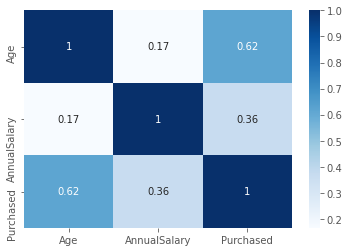

In [16]:
cor = car.corr()
sns.heatmap(cor, annot = True, cmap = 'Blues')
plt.show()

* We can see that there's a strong positive correlation between variable Age and our target 'Purchased'.
* we also can see a positive correlation between purchased and Annual Salary

## Data Preprocessing

### checking for Missing Values

In [17]:
car.isnull().sum().sort_values(ascending = False)

Gender          0
Age             0
AnnualSalary    0
Purchased       0
dtype: int64

### Variables encoding

In [18]:
car['Gender'] = car['Gender'].apply(lambda x : 0 if x == 'Male' else 1)

In [19]:
car.head(6)

,Gender,Age,AnnualSalary,Purchased
0,0,35,20000,0
1,0,40,43500,0
2,0,49,74000,0
3,0,40,107500,1
4,0,25,79000,0
5,1,47,33500,1


### Target and independant variables

In [20]:
X = car.drop('Purchased', axis = 1)
Y = car['Purchased']

### Data spliting

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 0)

### Data scalling

In [22]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Machine Learning

### 1- Logistic regression

In [23]:
logit = LogisticRegression()
logit.fit(X_train, Y_train)
print('interecept :', logit.intercept_, '\n', 'coeficients : ',logit.coef_ )

interecept : [-0.69851991] 
 coeficients :  [[-0.20180276  2.19625844  1.11631487]]


In [24]:
Y_logit = logit.predict(X_test)
print(classification_report(Y_test,Y_logit))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       152
           1       0.85      0.74      0.79        98

    accuracy                           0.85       250
   macro avg       0.85      0.83      0.84       250
weighted avg       0.85      0.85      0.85       250



In [25]:
accuracy_score(Y_test, Y_logit)

0.848

#### Looking for best parameters

In [27]:
param_logit = { 'C' : np.logspace(-3,3,7),
              'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}
logit2 =  LogisticRegression()
sh_logit = HalvingGridSearchCV(logit2, param_logit, cv=5,factor=2,max_resources=30).fit(X_train, Y_train)
sh_logit.best_estimator_

LogisticRegression(solver='liblinear')

In [28]:
Y_logit2 = sh_logit.predict(X_test)
print(classification_report(Y_test, Y_logit2))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       152
           1       0.85      0.74      0.79        98

    accuracy                           0.85       250
   macro avg       0.85      0.83      0.84       250
weighted avg       0.85      0.85      0.85       250



#### Confusion Matrix

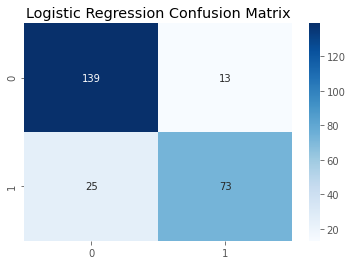

In [29]:
cmatrix_logit = confusion_matrix(Y_test, Y_logit2)
sns.heatmap(cmatrix_logit, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

#### Roc Curve

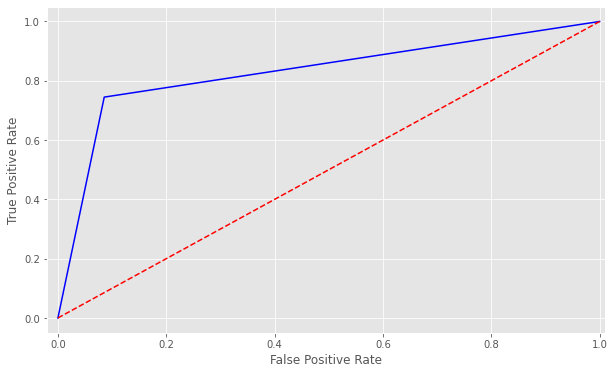

In [30]:
fpr, tpr, _ = roc_curve(Y_test,  Y_logit2)
plt.figure(figsize = (10,6))
plt.plot(fpr,tpr, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### 2- Decision Tree

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_dt = dt.predict(X_test)

In [32]:
print(classification_report(Y_dt, Y_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       159
           1       0.82      0.88      0.85        91

    accuracy                           0.88       250
   macro avg       0.87      0.88      0.88       250
weighted avg       0.89      0.88      0.88       250



In [33]:
accuracy_score(Y_dt, Y_test)

0.884

#### Looking for the best parameters

In [34]:
param_dt = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
dt2 =  DecisionTreeClassifier()
sh_dt = HalvingGridSearchCV(dt2, param_dt, cv=5,factor=2,max_resources=30).fit(X_train, Y_train)
sh_dt.best_estimator_

DecisionTreeClassifier(max_leaf_nodes=2)

In [35]:
Y_dt2 = sh_dt.predict(X_test)
print(classification_report(Y_dt2, Y_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       168
           1       0.68      0.82      0.74        82

    accuracy                           0.82       250
   macro avg       0.79      0.82      0.80       250
weighted avg       0.83      0.82      0.82       250



#### Confusion Matrix

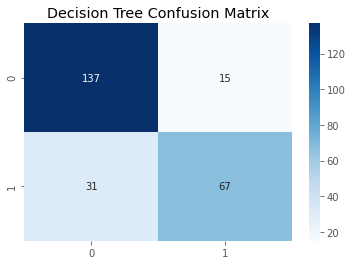

In [36]:
cmatrix_dt = confusion_matrix(Y_test, Y_dt2)
sns.heatmap(cmatrix_dt, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

#### Roc Curve

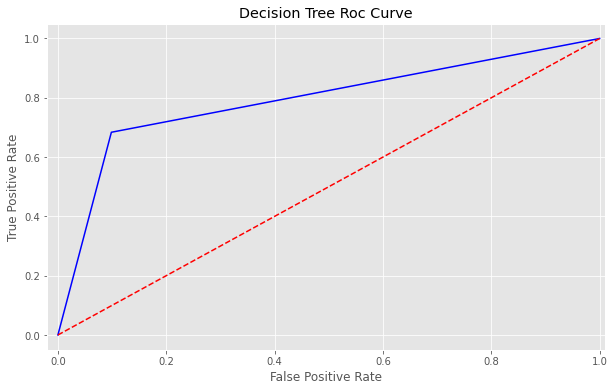

In [74]:
fpr2, tpr2, _ = roc_curve(Y_test,  Y_dt2)
plt.figure(figsize = (10,6))
plt.plot(fpr2,tpr2, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Roc Curve')
plt.show()

### 3- Random Forrest

In [38]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, Y_train)
Y_rf = rf.predict(X_test)
print(classification_report(Y_test,Y_rf))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       152
           1       0.87      0.83      0.85        98

    accuracy                           0.88       250
   macro avg       0.88      0.87      0.88       250
weighted avg       0.88      0.88      0.88       250



In [39]:
rf2 = RandomForestClassifier(random_state = 0)
param_grid = {'max_depth': [3,4, 5,6,8 ,10],'min_samples_split': [2, 5,6,7,8 ,10],'criterion':['gini','entropy'] }
sh = HalvingGridSearchCV(rf2, param_grid, cv=5,factor=2, resource='n_estimators',max_resources=40).fit(X_train, Y_train)
sh.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_split=5,
                       n_estimators=32, random_state=0)

In [40]:
Y_rf2= sh.predict(X_test)

In [41]:
print(classification_report(Y_rf2, Y_test))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       147
           1       0.91      0.86      0.89       103

    accuracy                           0.91       250
   macro avg       0.91      0.90      0.90       250
weighted avg       0.91      0.91      0.91       250



#### Confusion Matrix

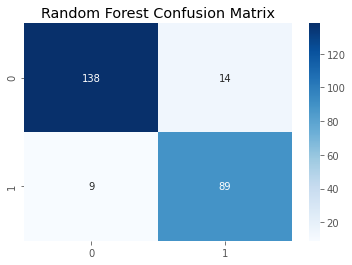

In [75]:
sns.heatmap(confusion_matrix(Y_test, Y_rf2), annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

#### Roc Curve

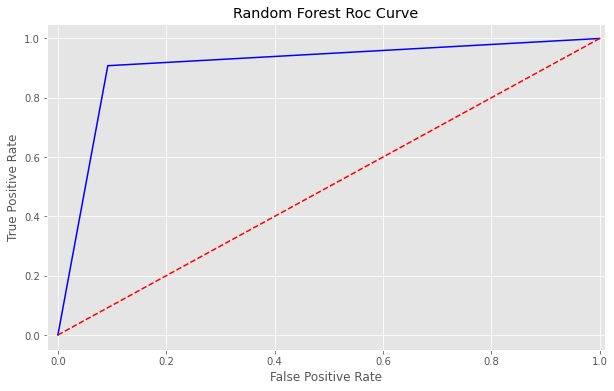

In [76]:
fpr3, tpr3, _ = roc_curve(Y_test,  Y_rf2)
plt.figure(figsize = (10,6))
plt.plot(fpr3,tpr3, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Roc Curve')
plt.show()

### 4- SVC

In [43]:
svc = svm.SVC()
svc.fit(X_train, Y_train)
Y_svc = svc.predict(X_test)
print(classification_report(Y_test, Y_svc))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       152
           1       0.87      0.88      0.87        98

    accuracy                           0.90       250
   macro avg       0.89      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



#### looking for best parameters

In [44]:
svc = svm.SVC()
param_svc = {'kernel': ['linear', 'poly', 'rbf','sigmoid'],'C': [2,3,4, 5,6,7,8 ,10],'gamma':['scale','auto'] }
sh_svc = HalvingGridSearchCV(svc, param_svc, cv=5,factor=2,max_resources=40).fit(X_train, Y_train)
sh_svc.best_estimator_

SVC(C=2, gamma='auto')

In [45]:
Y_svctr = sh_svc.predict(X_train)
Y_svc2 = sh_svc.predict(X_test)
print(classification_report(Y_svc2, Y_test))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       151
           1       0.88      0.87      0.87        99

    accuracy                           0.90       250
   macro avg       0.90      0.89      0.90       250
weighted avg       0.90      0.90      0.90       250



#### Confusion Matrix

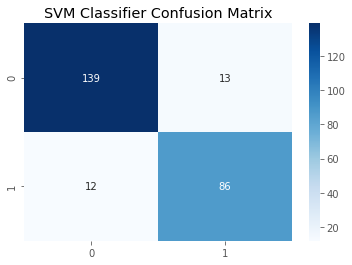

In [77]:
sns.heatmap(confusion_matrix(Y_test, Y_svc2), annot = True, fmt = 'd', cmap = 'Blues')
plt.title('SVM Classifier Confusion Matrix')
plt.show()

#### SVM Classifier Roc Curve

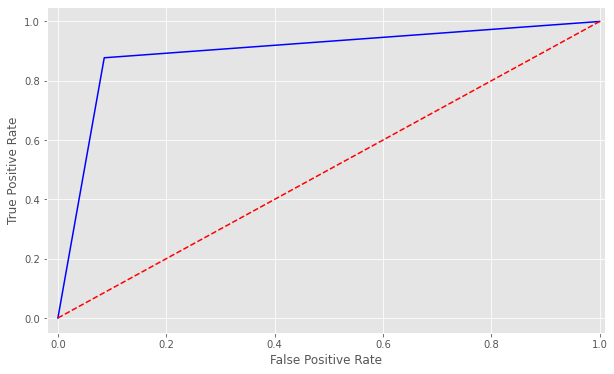

In [60]:
fpr4, tpr4, _ = roc_curve(Y_test,  Y_svc2)
plt.figure(figsize = (10,6))
plt.plot(fpr4,tpr4, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### 5- ADA Boost

In [47]:
RF = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(n_estimators=100, base_estimator = RF)
ada.fit(X_train, Y_train)

AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=0),
                   n_estimators=100)

In [48]:
Y_ada = ada.predict(X_test)
print(classification_report(Y_ada, Y_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       159
           1       0.83      0.89      0.86        91

    accuracy                           0.89       250
   macro avg       0.88      0.89      0.89       250
weighted avg       0.90      0.89      0.89       250



#### Confusion Matrix

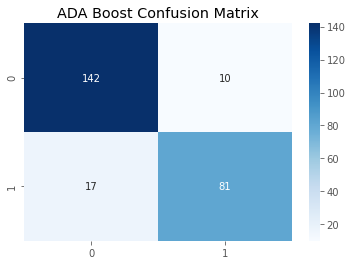

In [78]:
sns.heatmap(confusion_matrix(Y_test, Y_ada), annot = True, fmt = 'd', cmap = 'Blues')
plt.title('ADA Boost Confusion Matrix')
plt.show()

#### Roc Curve

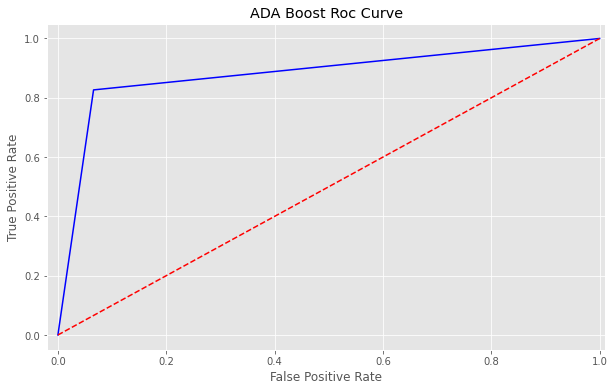

In [79]:
fpr5, tpr5, _ = roc_curve(Y_test,  Y_ada)
plt.figure(figsize = (10,6))
plt.plot(fpr5,tpr5, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADA Boost Roc Curve')
plt.show()

### 6- multilayer perceptron

In [51]:
X.shape

(1000, 3)

In [83]:
mlp = Sequential()
mlp.add(Dense(16, input_shape=(3,), activation = 'relu'))
mlp.add(Dropout(0.3))
mlp.add(Dense(8, activation = 'relu'))
mlp.add(Dropout(0.3))
mlp.add(Dense(1, activation = 'sigmoid'))
mlp.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')
history = mlp.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 1s 1ms/step - loss: 0.6456 - accuracy: 0.6440
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.6840
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5821 - accuracy: 0.7133
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.7467
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5215 - accuracy: 0.7547
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.7387
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.4724 - accuracy: 0.7733
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.7867
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.4615 - accuracy: 0.7827
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.4548 - accuracy: 0.7947
Epoch 11/

24/24 [==============================] - 0s 3ms/step - loss: 0.3042 - accuracy: 0.8867
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3206 - accuracy: 0.8800
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3007 - accuracy: 0.8907
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2955 - accuracy: 0.8987
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3295 - accuracy: 0.8840
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3075 - accuracy: 0.8760
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8773
Epoch 90/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3026 - accuracy: 0.8880
Epoch 91/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2864 - accuracy: 0.8933
Epoch 92/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.8800
Epoch 93/100


In [84]:
Y_mlp = (mlp.predict(X_test)>0.5).astype(int).tolist()
print(classification_report(Y_test,Y_mlp))

8/8 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       152
           1       0.87      0.91      0.89        98

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



#### Confusion Matrix

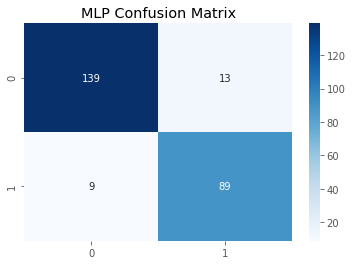

In [80]:
sns.heatmap(confusion_matrix(Y_test, Y_mlp), annot = True, fmt = 'd', cmap = 'Blues')
plt.title('MLP Confusion Matrix')
plt.show()

#### Roc Curve

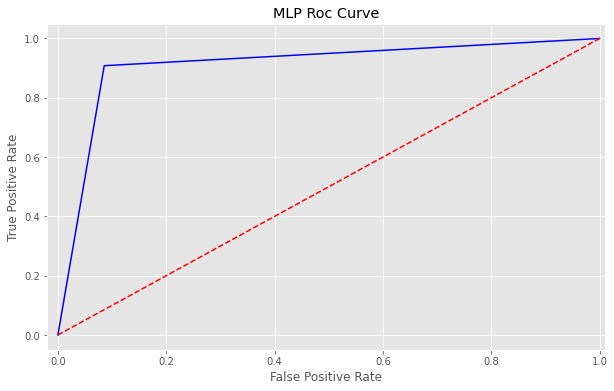

In [81]:
fpr6, tpr6, _ = roc_curve(Y_test,  Y_mlp)
plt.figure(figsize = (10,6))
plt.plot(fpr6,tpr6, 'b')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Roc Curve')
plt.show()

### Models Comparison

In [72]:
comp = pd.DataFrame({'Model' : ['Logistic Regression','Decision Tree','Random Forrest','SVM','Ada Boost','MLP'],'Test Accuracy':
                     [accuracy_score(Y_logit2, Y_test),accuracy_score(Y_dt2,Y_test) ,accuracy_score(Y_rf2,Y_test),
                   accuracy_score(Y_svc2,Y_test),accuracy_score(Y_ada, Y_test), accuracy_score(Y_mlp,Y_test)],
                                                             
             'f1-Score': [f1_score(Y_logit2, Y_test),f1_score(Y_dt2,Y_test) ,f1_score(Y_rf2,Y_test),
                  f1_score(Y_svc2,Y_test),f1_score(Y_ada, Y_test), f1_score(Y_mlp,Y_test)],'Roc Score':
                     [roc_auc_score(Y_logit2, Y_test),roc_auc_score(Y_dt2,Y_test),roc_auc_score(Y_rf2,Y_test)
                      ,roc_auc_score(Y_svc2,Y_test),roc_auc_score(Y_ada, Y_test),roc_auc_score(Y_mlp,Y_test)]})
comp.style.highlight_max(color = 'lightgreen', subset = 'Test Accuracy')

,Model,Test Accuracy,f1-Score,Roc Score
0,Logistic Regression,0.848000,0.793478,0.848199
1,Decision Tree,0.816000,0.744444,0.816275
2,Random Forrest,0.908000,0.885572,0.901427
3,SVM,0.900000,0.873096,0.894608
4,Ada Boost,0.892000,0.857143,0.891596
5,MLP,0.912000,0.890000,0.905869


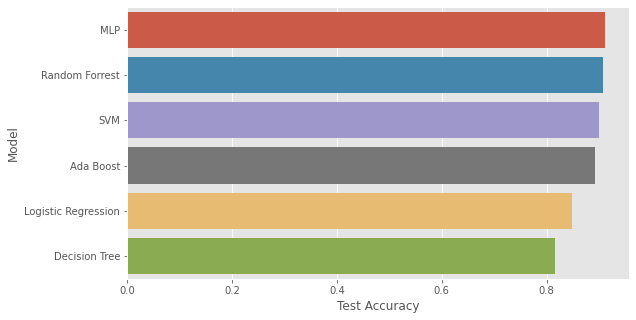

In [57]:
plt.figure(figsize = (9,5))
sns.barplot( data = comp.sort_values(by = 'Test Accuracy', ascending = False), y = 'Model', x = 'Test Accuracy')
plt.show()

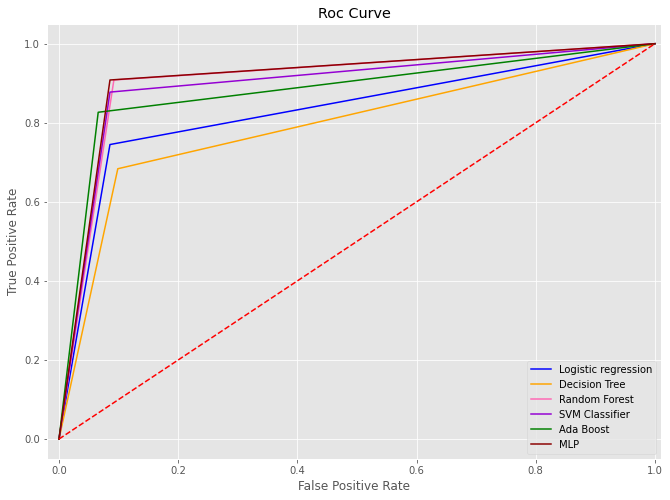

In [73]:
plt.figure(figsize = (11,8))
plt.plot(fpr,tpr, 'b', label = 'Logistic regression')
plt.plot(fpr2,tpr2, 'orange', label = 'Decision Tree')
plt.plot(fpr3,tpr3, 'hotpink', label = 'Random Forest')
plt.plot(fpr4,tpr4, 'darkviolet', label = 'SVM Classifier')
plt.plot(fpr5,tpr5, 'green', label = 'Ada Boost')
plt.plot(fpr6,tpr6, 'darkred', label = 'MLP')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([-0.02,1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc Curve')
plt.legend()
plt.show()

From the results we see that both multilayer perceptron and Random Forest are doing good.